DNN for predicting what stock to buy using tensorflow keras

Output 1 if stock is a buy, 0 if stock is a hold, -1 if stock is a sell

Input: stock data, technical indicators, and turbulence index

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [22]:
# load data from "../rl/single/train_data_multi.csv"
data_path = "../rl/single/train_data_single.csv"
data = pd.read_csv(data_path)

data_path_test = "../rl/single/trade_data_single.csv"
data_test = pd.read_csv(data_path_test)

features_test = data_test[["tic", "high", "low", "open", "volume", "day", "macd", "boll_ub", "boll_lb"]]
target_test = data_test['close']

features_test = pd.get_dummies(features_test, columns=['tic'])
features_test['day'] = pd.to_datetime(features_test['day'])
features_test['day'] = features_test['day'].dt.dayofweek



features = data[["tic", "high", "low", "open", "volume", "day", "macd", "boll_ub", "boll_lb"]]
target = data['close']

# one hot encode tic
features = pd.get_dummies(features, columns=['tic'])

# convert date to something useful for the model
features['day'] = pd.to_datetime(features['day'])
features['day'] = features['day'].dt.dayofweek



# Scale the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
features_test_scaled = scaler.transform(features_test)


# use data as the training data
X_train = features_scaled
y_train = target

X_test = features_test_scaled
y_test = target_test




# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Create DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Define the neural network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Instantiate the model, define the loss function and the optimizer
model = NeuralNetwork()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# Evaluate the model
model.eval()
with torch.no_grad():
    test_loss = 0
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item()
    test_loss /= len(test_loader)
    print(f"Test Loss: {test_loss}")

# Make predictions
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor).numpy()

print(predictions)



Epoch 1/200, Loss: 2168.396728515625
Epoch 2/200, Loss: 41.93451690673828
Epoch 3/200, Loss: 26.8018798828125
Epoch 4/200, Loss: 13.69713020324707
Epoch 5/200, Loss: 6.371518611907959
Epoch 6/200, Loss: 23.695240020751953
Epoch 7/200, Loss: 22.74071502685547
Epoch 8/200, Loss: 7.890480041503906
Epoch 9/200, Loss: 14.648893356323242
Epoch 10/200, Loss: 3.122650384902954
Epoch 11/200, Loss: 2.426208734512329
Epoch 12/200, Loss: 3.1478865146636963
Epoch 13/200, Loss: 2.0482194423675537
Epoch 14/200, Loss: 0.5615345239639282
Epoch 15/200, Loss: 2.7659518718719482
Epoch 16/200, Loss: 0.060922764241695404
Epoch 17/200, Loss: 0.17242971062660217
Epoch 18/200, Loss: 0.12014412879943848
Epoch 19/200, Loss: 2.024562358856201
Epoch 20/200, Loss: 0.012612487189471722
Epoch 21/200, Loss: 0.06651446968317032
Epoch 22/200, Loss: 3.488617420196533
Epoch 23/200, Loss: 0.4362863004207611
Epoch 24/200, Loss: 0.43142110109329224
Epoch 25/200, Loss: 2.4209649562835693
Epoch 26/200, Loss: 0.0726105496287345

In [23]:
# evluate the model

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score

mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)


print(f"MSE: {mse}")
print(f"MAE: {mae}")

# convert to a percentage for easier interpretation
mae = mae / np.mean(y_test) * 100
print(f"MAE: {mae}%")

# explain what that accuracy means
print("The Mean Absolute Error (MAE) is the average of the absolute differences between the predicted and actual values. It gives an idea of how wrong the predictions were.")
print("The percentage MAE is the MAE as a percentage of the average actual value. It gives an idea of how wrong the predictions were relative to the average actual value.")

MSE: 2.137281437227527
MAE: 1.2204170011531157
MAE: 0.75346987257985%
The Mean Absolute Error (MAE) is the average of the absolute differences between the predicted and actual values. It gives an idea of how wrong the predictions were.
The percentage MAE is the MAE as a percentage of the average actual value. It gives an idea of how wrong the predictions were relative to the average actual value.


98
Day 1: Predicted Close Price: 135.82, Actual Close Price: 137.38, Action: Hold, Cash: 10000.00, Stocks: 0, Portfolio Value: 10000.00, Confidence: 0.99
98
Day 2: Predicted Close Price: 137.68, Actual Close Price: 139.98, Action: Hold, Cash: 10000.00, Stocks: 0, Portfolio Value: 10000.00, Confidence: 0.98
99
Day 3: Predicted Close Price: 140.96, Actual Close Price: 141.32, Action: Hold, Cash: 10000.00, Stocks: 0, Portfolio Value: 10000.00, Confidence: 1.00
98
Day 4: Predicted Close Price: 143.23, Actual Close Price: 144.71, Action: Hold, Cash: 10000.00, Stocks: 0, Portfolio Value: 10000.00, Confidence: 0.99
99
Day 5: Predicted Close Price: 144.58, Actual Close Price: 145.40, Action: Hold, Cash: 10000.00, Stocks: 0, Portfolio Value: 10000.00, Confidence: 0.99
99
Day 6: Predicted Close Price: 143.58, Actual Close Price: 143.25, Action: Hold, Cash: 10000.00, Stocks: 0, Portfolio Value: 10000.00, Confidence: 1.00
99
Day 7: Predicted Close Price: 144.99, Actual Close Price: 144.23, Action:

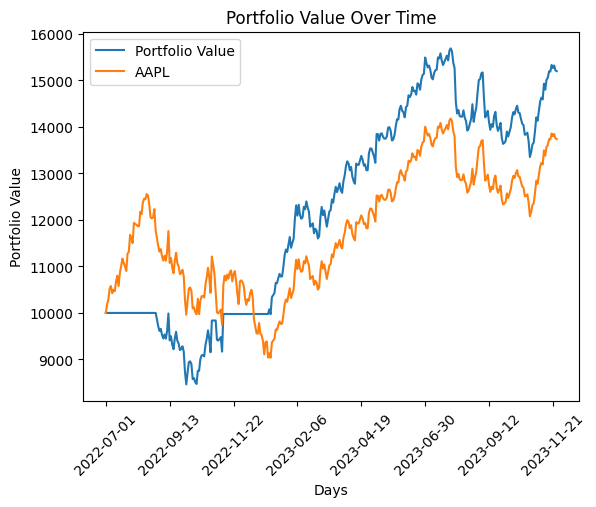

In [24]:
import matplotlib.pyplot as plt

# Define the action thresholds
threshold = 0.02  # 2%
max_shares_to_act = 100  # Maximum number of shares to buy or sell based on confidence

# Initialize portfolio
initial_amount = 10000  # Initial capital
cash = initial_amount
stocks = 0
portfolio_value = initial_amount

# Simulate trading based on predictions
actions = []
portfolio_values = []
cash_history = []

# Get the test data dates
dates = data_test["date"].values[-len(predictions) :]

for i in range(len(predictions)):
    current_price = y_test.values[i]
    predicted_price = predictions[i][0]
    confidence = abs(predicted_price - current_price) / current_price

    # Invert confidence so that it is proportional to the action
    confidence = 1 - confidence

    # Cap confidence at 1
    confidence = min(confidence, 1)

    # Determine the number of shares to buy or sell based on confidence
    shares_to_act = int(max_shares_to_act * confidence)
    print(shares_to_act)
    if shares_to_act == 0:
        shares_to_act = 1  # Ensure at least 1 share is acted on
    # print(predicted_price, current_price )
    # shares_to_act = 1
    if predicted_price > current_price * (1 + threshold):  # Buy condition
        if cash >= current_price * shares_to_act:  # Buy shares if we have enough cash
            stocks += shares_to_act
            cash -= current_price * shares_to_act
            action = f"Buy {shares_to_act} shares"
        else:
            action = "Buy as many shares as possible"
            shares_to_act = cash // current_price
            stocks += shares_to_act
            cash -= current_price * shares_to_act
    elif predicted_price < current_price * (1 - threshold):  # Sell condition
        if stocks >= shares_to_act:  # Sell shares if we have enough stocks
            stocks -= shares_to_act
            cash += current_price * shares_to_act
            action = f"Sell {shares_to_act} shares"
        else:
            action = "Sell all shares"
            cash += current_price * stocks
            stocks = 0

    else:
        action = "Hold"

    # Calculate portfolio value
    portfolio_value = cash + stocks * current_price
    portfolio_values.append(portfolio_value)
    cash_history.append(cash)

    actions.append(action)
    print(
        f"Day {i + 1}: Predicted Close Price: {predicted_price:.2f}, Actual Close Price: {current_price:.2f}, Action: {action}, Cash: {cash:.2f}, Stocks: {stocks}, Portfolio Value: {portfolio_value:.2f}, Confidence: {confidence:.2f}"
    )

# Print final portfolio value
print(f"Final Portfolio Value: {portfolio_value:.2f}")

# Plot the portfolio value over time (dates)
plt.plot(dates, portfolio_values)

# also plot the actual close price porfolio value
max_able_to_buy = initial_amount // y_test.values[0]
portfolio_values_single = []
cash = initial_amount
stocks = 0
for i in range(len(predictions)):
    current_price = y_test.values[i]
    if current_price < cash:
        stocks += max_able_to_buy
        cash -= current_price * max_able_to_buy
    portfolio_values_single.append(cash + stocks * current_price)

plt.plot(dates, portfolio_values_single)

# plt.plot(dates, cash_history)

plt.legend(["Portfolio Value", "AAPL"])


plt.xticks(dates[::50], rotation=45)
plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Portfolio Value Over Time")
plt.savefig("portfolio_value_single.png")
plt.show()